In [ ]:
import numpy as np
from itertools import permutations

class Stats:
    def __init__(self) -> None:
        self.fitness_history = []
        self.network = None
        self.fitness = None

class Params():
    def __init__(self, data, T0, p, alpha, mutation_prob, max_iterations, max_tests) -> None:
        self.data = data
        self.T0 = T0
        self.p = p
        self.alpha = alpha
        self.mutation_prob = mutation_prob
        self.max_iterations = max_iterations
        self.max_tests = max_tests

def comparator(x, y):
    if x > y:
        return y, x
    else:
        return x, y
    
def num_of_comparators(network):
    return sum(map(lambda t: t[-1], network))

def init_network(n):
    network = []
    for i in range(n):
        for j in range(i+1, n):
            network.append((i, j, True))
    return network

def apply_network(network, data):
    sorted_data = data.copy()
    for i, j, used in network:
        if used:
            sorted_data[i], sorted_data[j] = comparator(sorted_data[i], sorted_data[j])
    return sorted_data

def count_errors(network, input):
    ground_truth = np.sort(input)
    sorted_input = apply_network(network, input)
    return sum(1 for i in range(len(input)) if sorted_input[i] != ground_truth[i])

def test_max_n_cases(network, data, n):
    if np.math.factorial(len(data)) > n:
        return np.array([count_errors(network, input=np.random.permutation(data)) for _ in range(int(n))])
    else:
        return np.array([count_errors(network, np.array(permutation)) for permutation in list(permutations(data))])

def fitness(network, data, max_tests):
    errors = sum(test_max_n_cases(network, data, max_tests))
    fitness = num_of_comparators(network) + 10*errors**2
    return fitness

def mutate(network, prob):
    return list(map(lambda t: (t[0], t[1], not t[2]) if np.random.random() < prob else t, network))

def linear_temperature(T, alpha):
    while True:
        yield T
        T = T - alpha if T > alpha else 0

def power_temperature(T0, alpha, p):
    t = 0
    while True:
        yield T0 / (1 + (1-alpha) * t ** p)
        t += 1

def geometric_temperature(T, alpha):
    while True:
        yield T
        T *= alpha

def simulated_annealing(params:Params):
    stats = Stats()
    current_network = init_network(len(params.data))
    current_fitness = fitness(current_network, params.data, params.max_tests)
    best_network = current_network
    best_fitness = current_fitness
    T = params.T0
    eps = 1e-6
    schedule = power_temperature(T, params.alpha, params.p)
    for i in range(params.max_iterations):
        new_network = list(current_network)
        i, j = np.random.choice(range(len(new_network)), 2, replace=False)
        new_network[i], new_network[j] = new_network[j], new_network[i]
        new_network = mutate(new_network, params.mutation_prob)
        new_fitness = fitness(new_network, params.data, params.max_tests)
        delta_fitness = new_fitness - current_fitness
        if delta_fitness < 0 or np.random.random() < np.exp(-delta_fitness / (T + eps)):
            current_network = new_network
            current_fitness = new_fitness
        if current_fitness < best_fitness:
            best_network = current_network
            best_fitness = current_fitness
        T = next(schedule)
        stats.fitness_history.append(best_fitness)
    stats.network = best_network
    stats.fitness = best_fitness
    return stats


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import List

def best_error_fitness_history(runs, path, data, max_final_tests):
    best = min(runs, key=lambda x:x.fitness)
    print("Best sorting network:", best.network)
    print("Fitness:", best.fitness)
    print("Num of comparators:", num_of_comparators(best.network))

    results = test_max_n_cases(best.network, data, max_final_tests)
    all = len(results)
    errors = results[results != 0]
    invalid = len(errors)
    valid = len(results) - invalid
    accuracy = valid/all
    error = 1 - accuracy
    mean_error = np.mean(errors) if len(errors) > 0 else 0

    fig, ax = plt.subplots(figsize=(12.8, 7.2), dpi=100)
    bars, counts = np.unique(errors, return_counts=True)
    print(bars, counts)
    plt.bar(bars, counts, alpha=0.6)
    plt.xticks(bars, bars)
    textstr = '\n'.join((
        f"presnosť = {round(accuracy,3)}",
        f"chyba = {round(error,3)}",
        f'nesprávnych = {invalid}',
        f"priemerná \nveľkosť chyby = {round(mean_error, 3)}"))

    props = dict(boxstyle='round', facecolor='white', alpha=0.3)
    plt.text(0.832, 0.98, textstr, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, bbox=props)
    plt.xlabel("chyby")
    plt.ylabel("permutácie")
    fig.savefig(os.path.join(path, "all_errors.png"))

    fig = plt.figure(figsize=(12.8, 7.2), dpi=100)
    plt.plot(best.fitness_history)
    fig.savefig(os.path.join(path, "best_fitness_history.png"))

def fitness_history_graph(runs, path, max_iterations):
    fitness_history_runs = np.array([run.fitness_history for run in runs])

    mins = np.min(fitness_history_runs, axis=0)
    meds = np.median(fitness_history_runs, axis=0)
    maxs = np.max(fitness_history_runs, axis=0)
    var = np.var(fitness_history_runs, axis=0)

    fig = plt.figure(figsize=(12.8, 7.2), dpi=100)
    x = np.arange(1,max_iterations+1)
    plt.xscale('log')
    plt.plot(x,meds, label="median")
    plt.plot(x,mins, label="minimum")
    plt.fill_between(x,mins,maxs,alpha=0.4)
    plt.fill_between(x,meds-var,meds+var,alpha=0.2)
    plt.legend()
    plt.xlabel("počet iterácií")
    plt.ylabel("fitness")
    fig.savefig(os.path.join(path, "fitness_history.png"))

def plot_graphs(params, runs, path, max_final_tests):
    best_error_fitness_history(runs, path, params.data, max_final_tests)
    fitness_history_graph(runs, path, params.max_iterations)

def boxplot_graph(runs_to_compare, path):
    plt.figure(figsize=(12.8, 7.2), dpi=100)
    plt.boxplot([np.array([run.fitness for run in runs]) for runs in runs_to_compare], notch=True)
    plt.savefig(os.path.join(path, "boxplot.png"))

def run_mul_runs(params, num_of_runs, path, name, max_final_tests) -> List[Stats]:
    path = os.path.join(path, name)
    if not os.path.exists(path):
        os.mkdir(path)
    runs = []
    for i in range(num_of_runs):
        runs.append(simulated_annealing(params))
        np.save(os.path.join(path, "runs.npy"), np.array(runs))
        print(i+1, end=". ", flush=True)
    plot_graphs(params, runs, path, max_final_tests)
    print()
    return runs
        

params = Params(
    data = np.arange(1,16+1),
    T0 = 100.0,
    p = 2,
    alpha = 0.99,
    mutation_prob = 0.005,
    max_iterations = 10000,
    max_tests = 100
)
max_final_tests = 1e4

path="/stats"
if not os.path.exists(path):
    os.mkdir(path)


1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. Best sorting network: [(0, 6, True), (2, 14, True), (3, 13, True), (1, 11, True), (6, 11, True), (2, 5, True), (10, 11, False), (3, 9, True), (2, 4, True), (3, 10, True), (2, 13, True), (6, 7, True), (4, 14, False), (0, 7, False), (1, 5, True), (12, 14, True), (1, 14, True), (0, 9, True), (0, 5, True), (4, 13, True), (0, 12, True), (3, 6, True), (0, 4, True), (5, 13, True), (8, 13, True), (2, 10, True), (9, 14, True), (0, 14, True), (2, 6, True), (1, 10, False), (3, 12, True), (0, 1, True), (6, 13, True), (2, 8, True), (1, 7, True), (0, 3, True), (2, 11, True), (7, 11, True), (5, 14, True), (0, 11, True), (1, 6, True), (3, 5, True), (0, 2, True), (3, 8, True), (2, 7, False), (8, 9, True), (7, 9, True), (4, 7, True), (2, 12, True), (4, 10, True), (5, 11, True), (4, 8, True), (6, 9, False), (8, 11, True), (0, 8, True), (1, 3, True), (4, 11, False), (4, 12, True), (3, 7, False), 

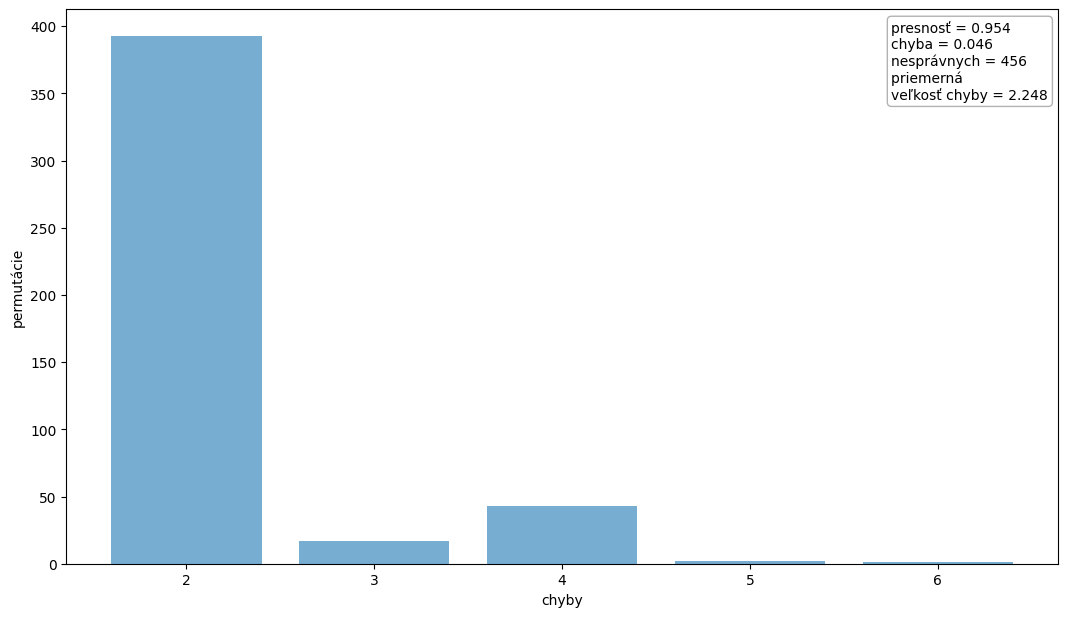

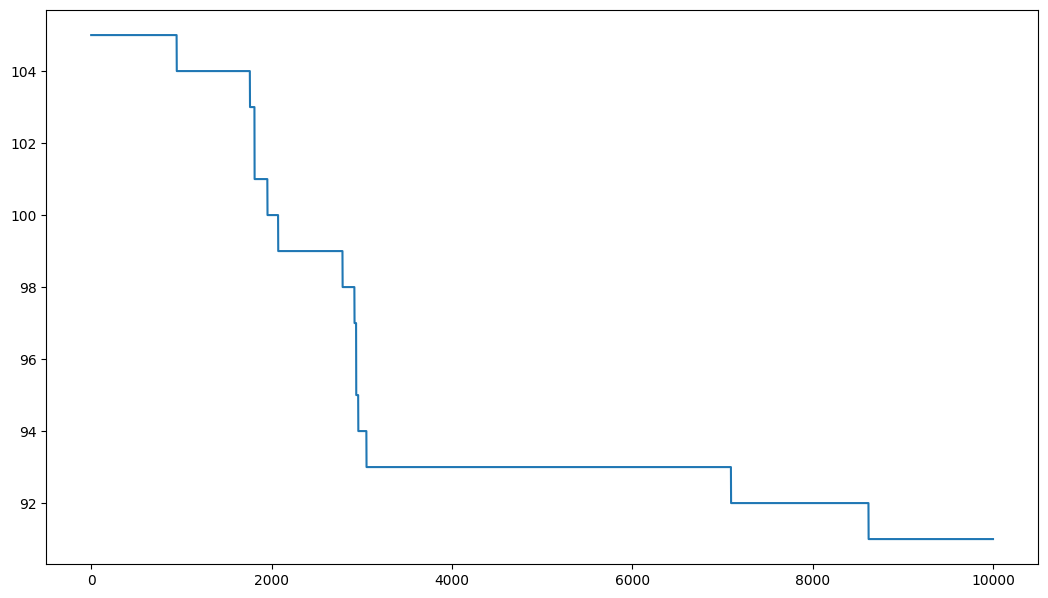

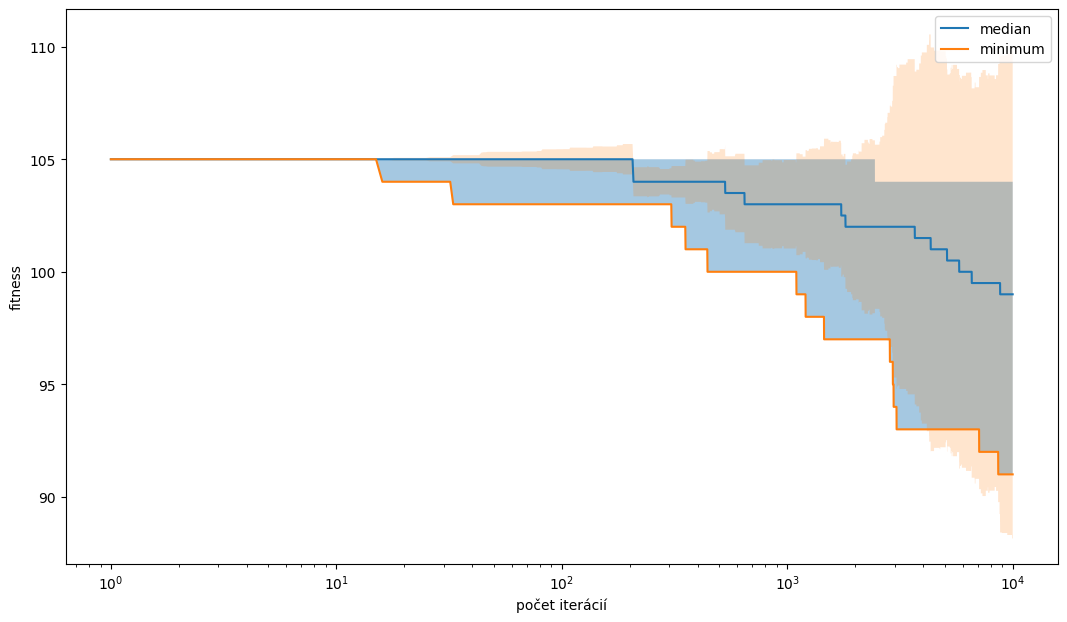

In [ ]:
alpha = 0.9
run1 = run_mul_runs(params, 30, path, "run1", max_final_tests)
!cp -R stats/run1 drive/MyDrive/VUT/EVO/pow/run1

{'data': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'T0': 100.0, 'p': 2, 'alpha': 0.6, 'mutation_prob': 0.005, 'max_iterations': 10000, 'max_tests': 100}
1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. Best sorting network: [(2, 6, True), (5, 8, True), (0, 3, True), (0, 12, False), (0, 9, True), (6, 8, True), (0, 10, True), (0, 8, False), (1, 8, True), (0, 6, True), (0, 11, False), (0, 4, True), (0, 5, True), (7, 9, True), (0, 15, True), (2, 5, False), (0, 14, True), (1, 6, True), (1, 5, True), (3, 10, True), (0, 7, True), (0, 13, True), (1, 4, True), (12, 14, True), (1, 11, True), (2, 4, True), (2, 12, True), (2, 15, True), (3, 9, True), (0, 1, True), (5, 12, True), (0, 2, True), (5, 15, True), (10, 11, True), (7, 12, True), (7, 10, True), (1, 9, True), (4, 8, True), (6, 11, True), (2, 13, True), (2, 8, False), (2, 10, False), (1, 14, True), (5, 10, False), (2, 9, True), (5, 11, False), (5, 9,

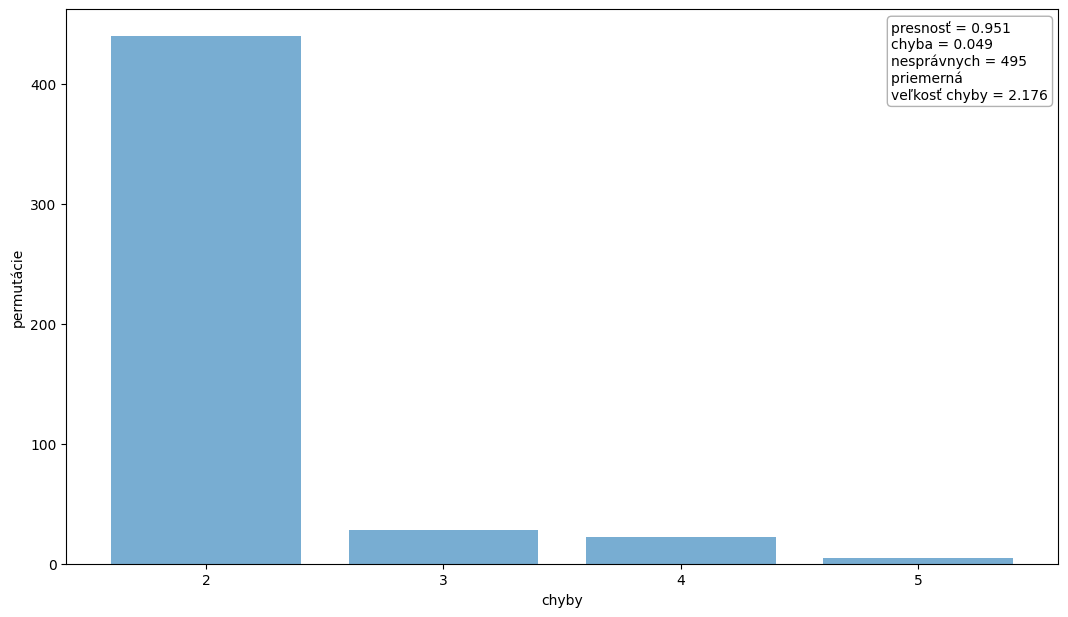

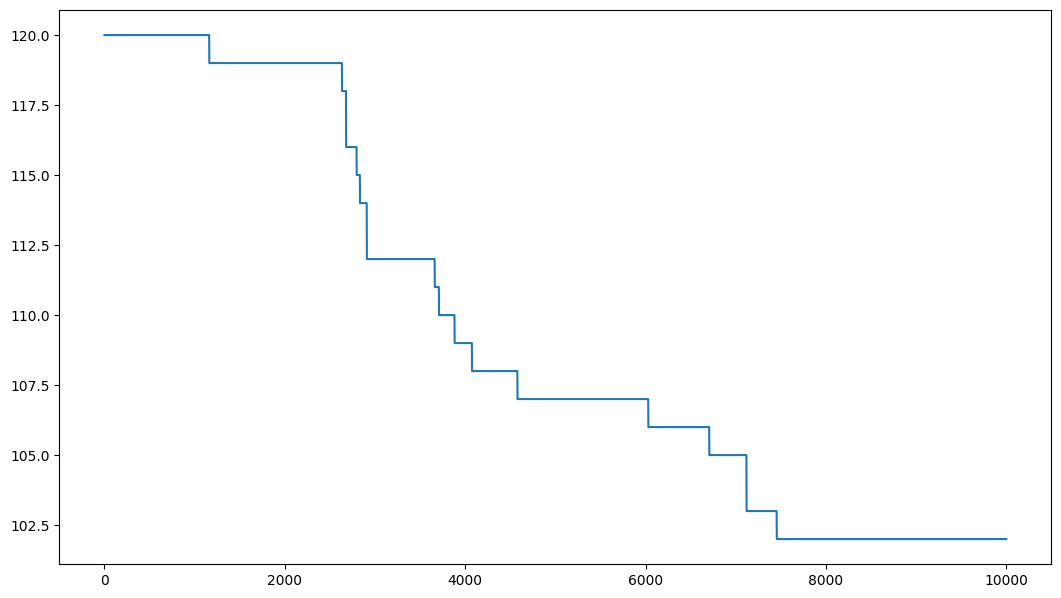

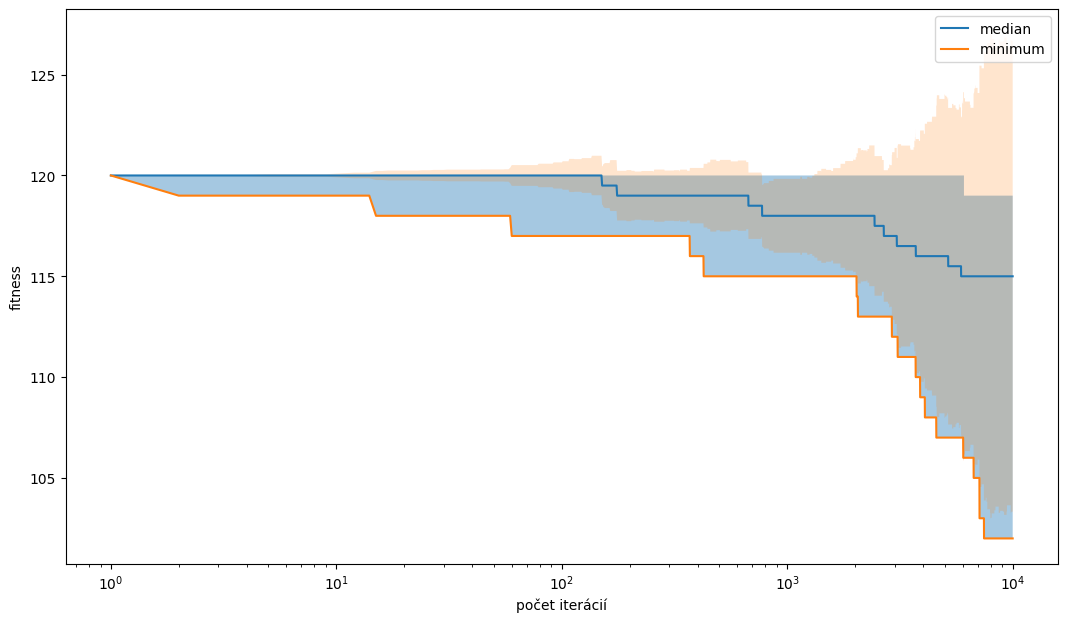

In [ ]:
alpha = 0.95
run2 = run_mul_runs(params, 30, path, "run2", max_final_tests)
!cp -R stats/run2 drive/MyDrive/VUT/EVO/pow/run2

{'data': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'T0': 100.0, 'p': 2, 'alpha': 0.8, 'mutation_prob': 0.005, 'max_iterations': 10000, 'max_tests': 100}
1. 2. 3. 4. 5. 6. 7. 8. 9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. Best sorting network: [(4, 11, True), (0, 2, True), (8, 11, True), (0, 4, True), (0, 5, True), (6, 11, False), (0, 7, True), (0, 14, True), (0, 6, True), (0, 13, True), (1, 4, True), (0, 10, True), (8, 12, True), (0, 12, True), (2, 5, True), (3, 11, False), (1, 13, False), (0, 8, True), (1, 15, True), (0, 3, True), (2, 11, True), (1, 7, True), (0, 1, True), (2, 15, True), (1, 11, True), (9, 14, True), (0, 9, True), (1, 3, True), (1, 8, True), (1, 9, True), (2, 10, True), (2, 4, True), (2, 6, True), (1, 5, False), (2, 8, True), (1, 14, True), (5, 7, False), (3, 5, True), (2, 12, True), (2, 13, True), (2, 14, True), (2, 7, True), (4, 7, True), (1, 2, True), (3, 6, True), (3, 7, True), (4, 9, False)

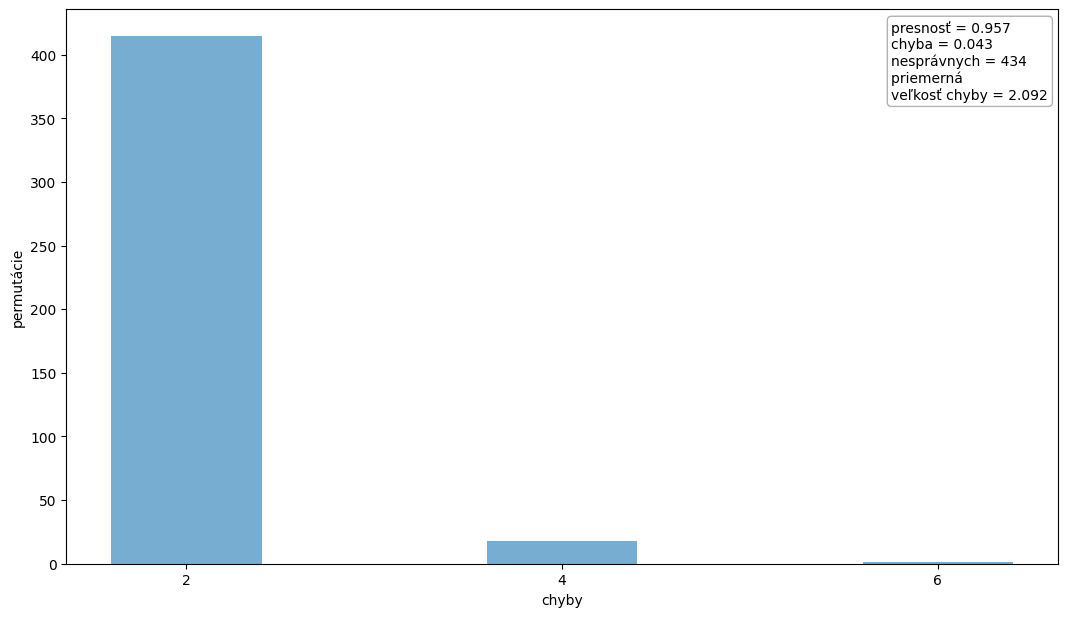

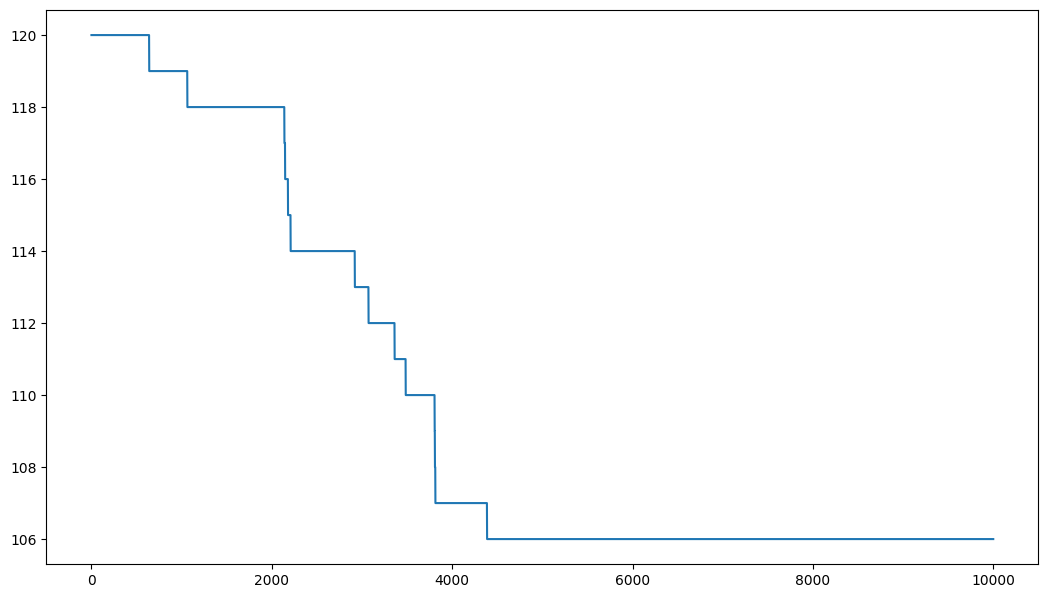

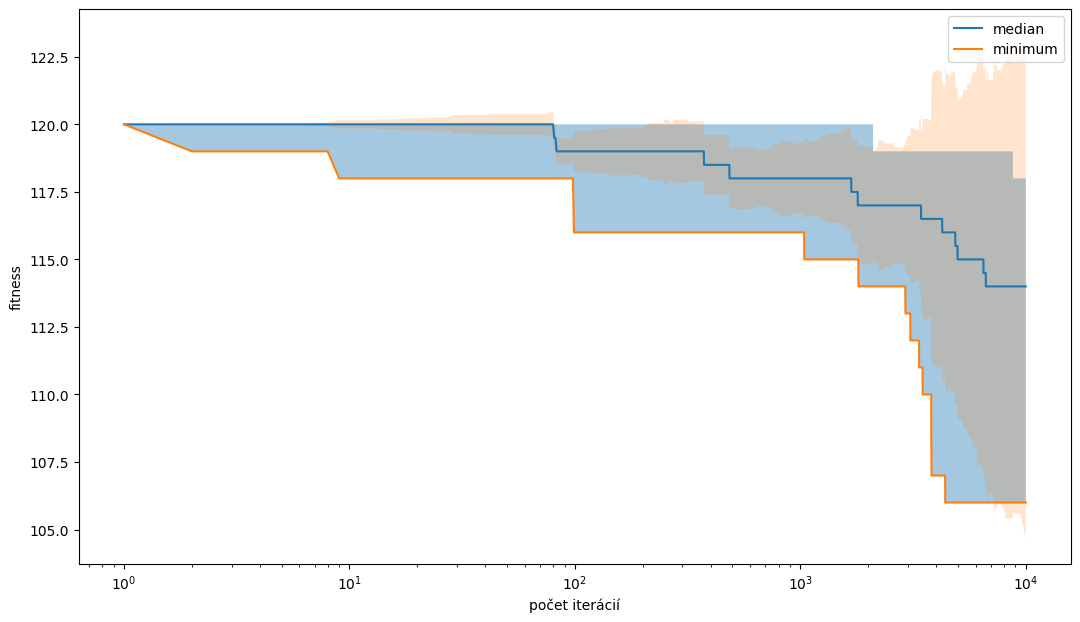

In [ ]:
alpha = 0.99
run3 = run_mul_runs(params, 30, path, "run3", max_final_tests)
!cp -R stats/run3 drive/MyDrive/VUT/EVO/pow/run3